# Lab 12 - Decision Tree regression

In this lab, we will return to the health insurance dataset used in Labs 7 and 9, and use *decision trees* to try to predict the policy cost, given information about the policy holder.  A decision tree is essentially a flow chart that is followed to make the predictions.

If you haven't already done so, watch the video introducing decision trees.

### Section 1: Installing the graphviz package

Follow the appropriate instructions for how you are running Python and Jupyter notebooks.

**Jupyter Hub on Lehman 360:**

1) Run the following code and wait until the [*] beside the cell changes to a number to continue (may take 5-10 min; if takes longer, try restarting the notebook).

2) Once graphviz is installed, click on "Kernel" in the top menu and then on "Restart" to restart the notebook.

In [2]:
pip install --user graphviz

Note: you may need to restart the kernel to use updated packages.


#### Google Colab:
The graphviz package should be installed.

#### Anaconda on your own computer:

Install graphviz the same way you installed folium.  

##### Instructions given in Lab 6:

1. In Anaconda Navigator, click on Environment in the left menu.
2. Select "Not installed" in the list.
3. Select folium and click "Apply" in the pop-up box.

[Instructions with images](https://docs.anaconda.com/anaconda/navigator/tutorials/manage-packages/#installing-a-package)

##### Install from the prompt/terminal:

Alternatively, on Windows: open the Anaconda Prompt (should be listed along with Jupyter Notebook) 

or on Mac or Linux: open the Terminal (on Mac under Applications -> Utilities -> Terminal)

Type and run the following in the prompt or terminal: 

`conda install -c anaconda graphviz`

### Section 2: Loading and cleaning the data

Run the following import statements.  If you get an error about graphviz, the package was not installed properly.  See above instructions and/or contact me for help.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import graphviz
 
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz

from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression

%matplotlib inline

Insurance data URL:  [https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv](https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv)

In this data, each row represents an insurance policy and the 7 columns contain the following information about it:
- age: age of policy holder
- sex: sex of policy holder
- bmi: boday mass index (bmi) of policy holder.  bmi is a (sometimes unreliable) measurement of body fat in adults
- children: number of children (dependents) on the policy
- smoker: whether the policy holder is a smoker
- region: region of the country the policy holder lives in
- charges: price for insurance policy

Load the insurance data into the DataFrame `insurance`:

In [2]:
insurance = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")
insurance

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


Decision trees can only use numeric data as the independent variables or *features*, so we have to convert the `sex`, `smoker`, and `region` columns into dummy variables as in Lab 9.

In [3]:
insurance = pd.get_dummies(insurance, columns = ["sex", "smoker", "region"], drop_first = True)

<details><summary>Answer:</summary>
<code>
insurance = pd.get_dummies(insurance, columns = ["sex", "smoker", "region"], drop_first = True)
    </code>
</details>

Display your new DataFrame to make sure the conversion was done correctly.

In [4]:
insurance

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,1,0,1,0,0
1334,18,31.920,0,2205.98080,0,0,0,0,0
1335,18,36.850,0,1629.83350,0,0,0,1,0
1336,21,25.800,0,2007.94500,0,0,0,0,1


### Section 3:  Fitting a decision tree with scikit-learn

To prepare the data for use by scikit-learn, we have to create a new DataFrame of only the independent variables or features, and a column of only the dependent variable, which we want to predict.  We also did this in Section 5 of Lab 9 to use scikit-learn to run linear regression on our data. 

First, create a new DataFrame called `x` of only the independent variables. 

In [5]:
x = insurance.drop(columns = ["charges"])
x.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,0,1,0,0,1
1,18,33.770,1,1,0,0,1,0
2,28,33.000,3,1,0,0,1,0
3,33,22.705,0,1,0,1,0,0
4,32,28.880,0,1,0,1,0,0


Next create a Series called `y` of only the `charges` column.

In [6]:
y = insurance["charges"]
y.head()

0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: charges, dtype: float64

Now we create the decision tree regressor variable, called `model`, and fit it to our data:

In [7]:
model = DecisionTreeRegressor(max_depth = 3)
model.fit(x, y)

DecisionTreeRegressor(max_depth=3)

If you are running this notebook on your own computer or in Google Colabs, you may be able to display the decision tree by first importing the function `plot_tree` and then running it.

In [8]:
# will give error in Jupyter Hub on Lehman 360
from sklearn.tree import plot_tree

[Text(581.25, 990.9375, 'smoker_yes <= 0.5\nmse = 146542766.494\nsamples = 1338\nvalue = 13270.422'),
 Text(290.625, 707.8125, 'age <= 42.5\nmse = 35891656.003\nsamples = 1064\nvalue = 8434.268'),
 Text(145.3125, 424.6875, 'children <= 0.5\nmse = 22145208.607\nsamples = 596\nvalue = 5398.85'),
 Text(72.65625, 141.5625, 'mse = 16936983.559\nsamples = 253\nvalue = 3850.841'),
 Text(217.96875, 141.5625, 'mse = 22915523.402\nsamples = 343\nvalue = 6540.675'),
 Text(435.9375, 424.6875, 'age <= 51.5\nmse = 26721037.099\nsamples = 468\nvalue = 12299.887'),
 Text(363.28125, 141.5625, 'mse = 20456563.503\nsamples = 199\nvalue = 10193.097'),
 Text(508.59375, 141.5625, 'mse = 25642708.343\nsamples = 269\nvalue = 13858.442'),
 Text(871.875, 707.8125, 'bmi <= 30.01\nmse = 132721153.136\nsamples = 274\nvalue = 32050.232'),
 Text(726.5625, 424.6875, 'age <= 41.0\nmse = 25281960.654\nsamples = 130\nvalue = 21369.223'),
 Text(653.90625, 141.5625, 'mse = 12049437.126\nsamples = 73\nvalue = 18474.022'),


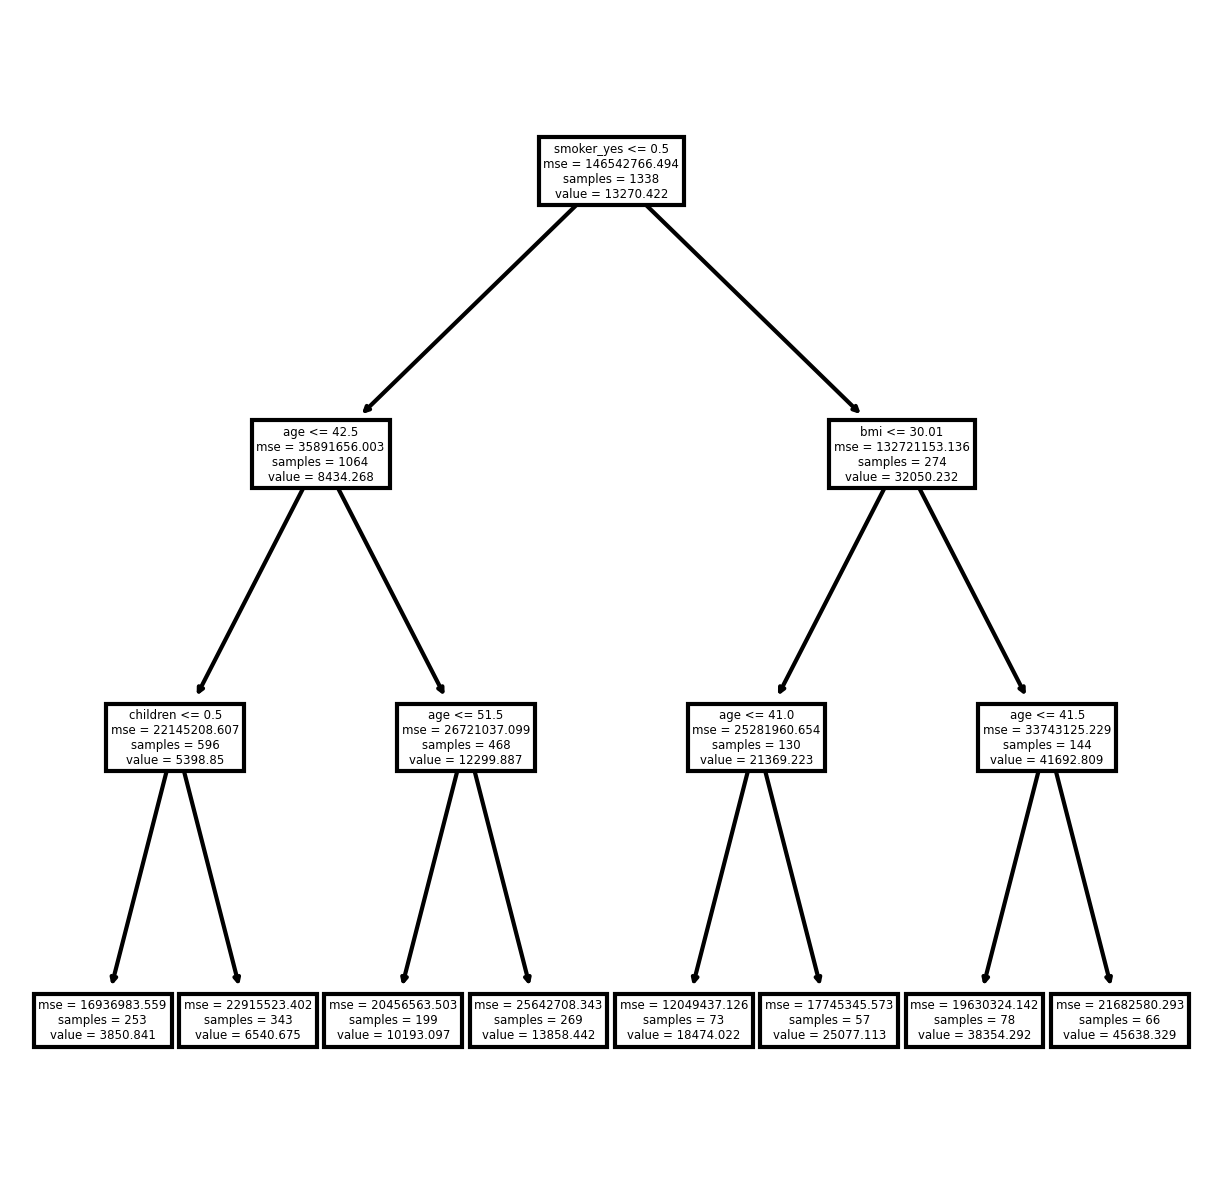

In [14]:
# will give error in Jupyter Hub on Lehman 360

# following line of code can be used to adjust the figsize to make it readable
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5), dpi=300)
plot_tree(model, feature_names= x.columns)

If you are using Jupyter Hub on Lehman 360, run the following code (which will give an error):

In [10]:
dot_data = export_graphviz(model, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("insurance.dot")

ExecutableNotFound: failed to execute ['dot', '-Kdot', '-Tpdf', '-O', 'insurance.dot'], make sure the Graphviz executables are on your systems' PATH

Despite the error, there should now be a file called `insurance.dot` in your directory.  To view the fitted decision tree, open the `insurance.dot` file in Jupyter and copy the text.  Paste this text into the text box at [http://www.webgraphviz.com](http://www.webgraphviz.com) and click the "Generate graph!" button at the bottom.

The column names have been replaced by `X[0], X[1], ..., X[7]`.  To change these to the actual column names do the following:

* If `plot_tree()` worked, add the parameter `feature_names= x.columns` to `plot_tree()` and re-run the code.



* If you created a `.dot` file, run the following code to create a new file called `insurance_fixed.dot` from `insurance.dot` that has `X[0], X[1], ..., X[7]` replaced by the original column names.  As with `insurance.dot`, copy the contents of `insurance_fixed.dot` in the text box at [http://www.webgraphviz.com](http://www.webgraphviz.com) to view the new tree.

In [12]:
with open ("insurance.dot", "r") as fin:
    with open("insurance_fixed.dot","w") as fout:
        for line in fin.readlines():
            line = line.replace("X[0]","age")
            line = line.replace("X[1]","bmi")
            line = line.replace("X[2]","children")
            line = line.replace("X[3]","sex_male")
            line = line.replace("X[4]","smoker_yes")
            line = line.replace("X[5]","region_northwest")            
            line = line.replace("X[6]","region_southeast")
            line = line.replace("X[7]","region_southwest")
            fout.write(line)

Which column is the first decision based on?  Does this make sense?

Which columns are the decisions in the next row based on?

How many levels are in the tree?  How do you think this relates to the tree having a max depth of 3?

What value is predicted by the decision tree for someone who is a smoker, age 50, and has a bmi of 27?

What value is predicted by the deicsion tree for someone who is not a smoker, age 37, and has a bmi of 23?

What happens if you change the `max_depth` parameter to 5 in DecisionTreeRegressor?

Look at the leaves of the tree.  What's the smallest sample?  Are the sample sizes somewhat evenly distributed?  

Very small sample sizes in some of the leaves can be a sign of overfitting.  In a decision tree, a too large max depth leads to overfitting, while a too small max depth leads to underfitting.


### Section 4: Training and testing data

In Lab 10, we simulated different training and testing datasets to look for overfitting by comparing the mean squared error (MSE).  We cannot simulate more insurance data, but we can divide our existing dataset into two parts:  a training dataset and a testing dataset.  We will train our model on only the training data, and then test it on only the testing data.

The `train_test_split` function in scikit-learn will randomly divide our data into two parts.  The parameter `test_size` tells scikit-learn what proportion of the original data should becomes test data.

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

What do you think is was assigned to the variables `x_train`, `x_test`, `y_train`, and `y_test`?  Display them below to see if you are correct.

In [16]:
x_train

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
276,19,20.615,2,1,0,1,0,0
72,53,28.100,3,0,0,0,0,1
948,42,31.255,0,1,0,1,0,0
1299,19,25.745,1,0,0,1,0,0
687,40,41.690,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...
440,31,32.680,1,0,0,1,0,0
15,19,24.600,1,1,0,0,0,1
132,53,35.900,2,0,0,0,0,1
1233,58,23.300,0,1,0,0,0,1


In [17]:
x_test

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
28,23,17.385,1,1,0,1,0,0
741,27,29.150,0,1,1,0,1,0
695,26,40.185,0,0,0,1,0,0
812,54,21.010,2,1,0,0,1,0
970,50,28.160,3,0,0,0,1,0
...,...,...,...,...,...,...,...,...
927,57,20.100,1,0,0,0,0,1
785,35,27.700,3,0,0,0,0,1
32,19,28.600,5,0,0,0,0,1
370,61,21.090,0,0,0,1,0,0


In [18]:
y_train

276      2803.69785
72      11741.72600
948      6358.77645
1299     2710.82855
687      5438.74910
           ...     
440      4738.26820
15       1837.23700
132     11163.56800
1233    11345.51900
1274    17043.34140
Name: charges, Length: 1070, dtype: float64

In [19]:
y_test

28       2775.19215
741     18246.49550
695      3201.24515
812     11013.71190
970     10702.64240
           ...     
927     12032.32600
785      6414.17800
32       4687.79700
370     13415.03810
1101    11253.42100
Name: charges, Length: 268, dtype: float64

Create a decision tree with `max_depth = 3` from the training data:

In [39]:
tree3 = DecisionTreeRegressor(max_depth = 4)
tree3.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=4)

<details><summary>Answer:</summary>
<code>
reg3 = DecisionTreeRegressor(max_depth = 3)
reg3 = reg3.fit(x_train, y_train)
</code>
</details>

Make predictions for the test data:

In [40]:
preds3_test = tree3.predict(x_test)

<details><summary>Answer:</summary>
<code>
predictions_3 = reg3.predict(x_test)
</code>
</details>

Compute the mean squared error for these predictions:

In [42]:
mean_squared_error(preds3_test, y_test)

23427293.30285138

<details><summary>Answer:</summary>
<code>
mean_squared_error(predictions_3, y_test)
</code>
</details>

Next make predictions using the training data and compute the mean squared error for these predictions.

In [43]:
preds3_train = tree3.predict(x_train)

In [44]:
mean_squared_error(preds3_train,y_train)

19567222.991940692

max_depth = 3
MSE test: 23,957,896
MSE train: 21,127,102

max_depth = 2 -> underfitting?
MSE test: 27,428,952
MSE train: 25,314,856

max_depth = 10 -> overfitting
MSE test: 39,362,083
MSE train: 4,283,699

max_depth = 4
MSE test: 23,427,293
MSE train: 19,567,222

How do the two mean squared errors compare?  If the mean squared error of the testing data is a lot higher than the mean squared error of the training, then this is a sign that overfitting is happening.

Write down or copy the mean squared errors into a blank cell to "store" them.  Now try re-running the above code with a smaller max depth.  How do the training and testing mean squared errors change?  What do you think this means?

Next re-run the above code with a larger max depth. How do the training and testing mean squared errors change?  What do you think this means?

What do you think the best max depth is for this data?  We will compare the decision tree model with that max depth to a linear regression model in the next section.

### Section 5:  Comparison to Linear Regression

Finally, let's determine with a decision tree or linear regression does a better job at predicting health insurance policy costs.

Using the same training and testing data as above, fit a linear regression model (using scikit-learn) to the training data.

In [45]:
lin_model = LinearRegression()
lin_model.fit(x_train,y_train)

LinearRegression()

Use this linear regression model to make predictions for the test data.

In [46]:
y_test_preds_lin = lin_model.predict(x_test)

Compute the mean squared error of these linear regression model predictions.

In [47]:
mean_squared_error(y_test_preds_lin, y_test)

35333367.35015409

How does the mean squared error of the linear model for the test data compare to the mean squared error of the best decision tree model picked in Section 4?  

Which model to you think makes the best predictions?